Customized-LLM-Based-Tutor

In [5]:
# Standard library imports
import os
import time
import json
from typing import Dict, List, Any, Optional, Union, Callable

# Third-party imports
from dotenv import load_dotenv
from IPython.display import Markdown, display, HTML, update_display
from openai import OpenAI
import ollama
import pandas as pd
import matplotlib.pyplot as plt

# Try to import rich, install if not available
try:
    from rich.console import Console
    from rich.markdown import Markdown as RichMarkdown
    from rich.panel import Panel
except ImportError:
    !pip install rich
    from rich.console import Console
    from rich.markdown import Markdown as RichMarkdown
    from rich.panel import Panel


In [6]:

# Constants
MODEL_GPT = 'gpt-4o-mini'
MODEL_LLAMA = 'llama3.2'
DEFAULT_SYSTEM_PROMPT = "You are a helpful technical tutor who answers questions about python code, software engineering, data science and LLMs"

# Set up environment
load_dotenv()
openai = OpenAI()
console = Console()


In [7]:

class LLMTutor:
    """
    A class that provides tutoring functionality using multiple LLM models.
    """
    
    def __init__(self, 
                 system_prompt: str = DEFAULT_SYSTEM_PROMPT,
                 gpt_model: str = MODEL_GPT,
                 llama_model: str = MODEL_LLAMA):
        """
        Initialize the LLM Tutor with specified models and system prompt.
        
        Args:
            system_prompt: The system prompt to use for the LLMs
            gpt_model: The OpenAI GPT model to use
            llama_model: The Ollama model to use
        """
        self.system_prompt = system_prompt
        self.gpt_model = gpt_model
        self.llama_model = llama_model
        self.history: List[Dict[str, Any]] = []
        self.response_times = {'gpt': [], 'llama': []}
        
    def format_question(self, question: str) -> str:
        """
        Format the user's question with a standard prefix.
        
        Args:
            question: The user's question
            
        Returns:
            Formatted question with prefix
        """
        return f"Please give a detailed explanation to the following question: {question}"
    
    def create_messages(self, question: str) -> List[Dict[str, str]]:
        """
        Create the message structure for LLM API calls.
        
        Args:
            question: The user's question
            
        Returns:
            List of message dictionaries
        """
        formatted_question = self.format_question(question)
        return [
            {"role": "system", "content": self.system_prompt},
            {"role": "user", "content": formatted_question}
        ]
    
    def get_gpt_response(self, 
                        question: str, 
                        stream: bool = True) -> str:
        """
        Get a response from the GPT model.
        
        Args:
            question: The user's question
            stream: Whether to stream the response
            
        Returns:
            The model's response as a string
        """
        messages = self.create_messages(question)
        start_time = time.time()
        
        try:
            if stream:
                return self._stream_gpt_response(messages)
            else:
                response = openai.chat.completions.create(
                    model=self.gpt_model, 
                    messages=messages
                )
                elapsed = time.time() - start_time
                self.response_times['gpt'].append(elapsed)
                return response.choices[0].message.content
        except Exception as e:
            console.print(f"[bold red]Error with GPT model:[/bold red] {str(e)}")
            return f"Error: {str(e)}"
    
    def _stream_gpt_response(self, messages: List[Dict[str, str]]) -> str:
        """
        Stream a response from the GPT model.
        
        Args:
            messages: The messages to send to the model
            
        Returns:
            The complete response as a string
        """
        start_time = time.time()
        try:
            stream = openai.chat.completions.create(
                model=self.gpt_model, 
                messages=messages,
                stream=True
            )
            
            response = ""
            display_handle = display(Markdown(""), display_id=True)
            
            for chunk in stream:
                delta_content = chunk.choices[0].delta.content or ''
                response += delta_content
                # Clean the response for display
                clean_response = response.replace("```python", "```").replace("```", "")
                update_display(Markdown(clean_response), display_id=display_handle.display_id)
            
            elapsed = time.time() - start_time
            self.response_times['gpt'].append(elapsed)
            return response
        except Exception as e:
            console.print(f"[bold red]Error streaming GPT response:[/bold red] {str(e)}")
            return f"Error: {str(e)}"
    
    def get_llama_response(self, question: str) -> str:
        """
        Get a response from the Llama model.
        
        Args:
            question: The user's question
            
        Returns:
            The model's response as a string
        """
        messages = self.create_messages(question)
        start_time = time.time()
        
        try:
            response = ollama.chat(model=self.llama_model, messages=messages)
            elapsed = time.time() - start_time
            self.response_times['llama'].append(elapsed)
            return response['message']['content']
        except Exception as e:
            console.print(f"[bold red]Error with Llama model:[/bold red] {str(e)}")
            return f"Error: {str(e)}"
    
    def ask(self, question: str, models: List[str] = ['gpt', 'llama']) -> Dict[str, str]:
        """
        Ask a question to one or more models.
        
        Args:
            question: The user's question
            models: List of models to query ('gpt', 'llama', or both)
            
        Returns:
            Dictionary with model responses
        """
        responses = {}
        
        # Store the question in history
        self.history.append({
            'question': question,
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'responses': {}
        })
        
        # Get responses from requested models
        if 'gpt' in models:
            console.print(Panel(f"[bold blue]Getting response from {self.gpt_model}...[/bold blue]"))
            gpt_response = self.get_gpt_response(question)
            responses['gpt'] = gpt_response
            self.history[-1]['responses']['gpt'] = gpt_response
            
        if 'llama' in models:
            console.print(Panel(f"[bold green]Getting response from {self.llama_model}...[/bold green]"))
            llama_response = self.get_llama_response(question)
            responses['llama'] = llama_response
            self.history[-1]['responses']['llama'] = llama_response
            display(Markdown(f"## {self.llama_model} Response\n{llama_response}"))
            
        return responses
    
    def compare_responses(self, question: str = None) -> None:
        """
        Compare responses from different models side by side.
        
        Args:
            question: Optional specific question to compare responses for
        """
        if question:
            responses = self.ask(question)
        else:
            # Use the most recent question from history
            if not self.history:
                console.print("[bold red]No questions in history to compare[/bold red]")
                return
            responses = self.history[-1]['responses']
            question = self.history[-1]['question']
        
        # Create HTML for side-by-side comparison
        html = f"""
        <div style="display: flex; width: 100%;">
            <div style="flex: 1; padding: 10px; border: 1px solid #ddd; border-radius: 5px; margin-right: 10px;">
                <h3 style="color: #4285F4;">{self.gpt_model}</h3>
                <div style="white-space: pre-wrap;">{responses.get('gpt', 'No response')}</div>
            </div>
            <div style="flex: 1; padding: 10px; border: 1px solid #ddd; border-radius: 5px;">
                <h3 style="color: #34A853;">{self.llama_model}</h3>
                <div style="white-space: pre-wrap;">{responses.get('llama', 'No response')}</div>
            </div>
        </div>
        """
        display(HTML(html))
    
    def show_performance_metrics(self) -> None:
        """
        Display performance metrics for the models.
        """
        if not self.response_times['gpt'] and not self.response_times['llama']:
            console.print("[bold yellow]No performance data available yet[/bold yellow]")
            return
        
        # Create DataFrame for metrics
        data = {
            'Model': [],
            'Response Time (s)': []
        }
        
        for model, times in self.response_times.items():
            for t in times:
                data['Model'].append(model)
                data['Response Time (s)'].append(t)
        
        df = pd.DataFrame(data)
        
        # Calculate statistics
        stats = df.groupby('Model')['Response Time (s)'].agg(['mean', 'min', 'max', 'count'])
        
        # Display statistics
        console.print("\n[bold]Performance Statistics:[/bold]")
        console.print(stats)
        
        # Create visualization
        plt.figure(figsize=(10, 6))
        
        # Box plot
        ax = plt.subplot(1, 2, 1)
        df.boxplot(column='Response Time (s)', by='Model', ax=ax)
        plt.title('Response Time Distribution')
        plt.suptitle('')
        
        # Bar chart for average times
        ax = plt.subplot(1, 2, 2)
        stats['mean'].plot(kind='bar', ax=ax, color=['#4285F4', '#34A853'])
        plt.title('Average Response Time')
        plt.ylabel('Seconds')
        
        plt.tight_layout()
        plt.show()
    
    def save_history(self, filename: str = 'tutor_history.json') -> None:
        """
        Save the question and response history to a file.
        
        Args:
            filename: The filename to save to
        """
        try:
            with open(filename, 'w') as f:
                json.dump(self.history, f, indent=2)
            console.print(f"[bold green]History saved to {filename}[/bold green]")
        except Exception as e:
            console.print(f"[bold red]Error saving history:[/bold red] {str(e)}")
    
    def load_history(self, filename: str = 'tutor_history.json') -> None:
        """
        Load question and response history from a file.
        
        Args:
            filename: The filename to load from
        """
        try:
            with open(filename, 'r') as f:
                self.history = json.load(f)
            console.print(f"[bold green]History loaded from {filename}[/bold green]")
        except FileNotFoundError:
            console.print(f"[bold yellow]History file {filename} not found[/bold yellow]")
        except Exception as e:
            console.print(f"[bold red]Error loading history:[/bold red] {str(e)}")


In [8]:

# Create a tutor instance
tutor = LLMTutor()
console.print("[bold green]LLM Tutor initialized successfully![/bold green]")


LLM Tutor initialized successfully!

In [9]:

# Define your question here
question = """
Given a list of dictionaries called 'books', write code to find and print all information 
about the book titled 'Mastery' by Robert Greene.
"""

console.print(Panel(f"[bold]Question:[/bold]\n{question}", border_style="blue"))


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Question:                                                                                                       │
│                                                                                                                 │
│ Given a list of dictionaries called 'books', write code to find and print all information                       │
│ about the book titled 'Mastery' by Robert Greene.                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [10]:

# Get responses from both models
responses = tutor.ask(question)


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Getting response from gpt-4o-mini...                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

To find and print all information about the book titled 'Mastery' by Robert Greene from a list of dictionaries called `books`, you can follow these steps:

1. **Understand the Structure**: Assume the `books` list is composed of dictionaries where each dictionary represents a book. Each book dictionary may have keys like `title`, `author`, `year`, and `genre`, among others.

2. **Iterate through the List**: You will need to iterate over each dictionary (representing a book) in the list. For each book, you'll check if it matches the target title ('Mastery') and author (Robert Greene).

3. **Print Information**: If a match is found, print all the information contained in that dictionary.

Here's a step-by-step implementation of this logic in Python:


books = [
    {
        'title': 'Mastery',
        'author': 'Robert Greene',
        'year': 2012,
        'genre': 'Non-Fiction',
        'summary': 'A guide to achieving excellence in any field by mastering skills.'
    },
    {
        'title': 'The 48 Laws of Power',
        'author': 'Robert Greene',
        'year': 1998,
        'genre': 'Non-Fiction',
        'summary': 'A practical guide to gaining and maintaining power.'
    },
    {
        'title': 'The Alchemist',
        'author': 'Paulo Coelho',
        'year': 1988,
        'genre': 'Fiction',
        'summary': 'A philosophical story about following your dreams.'
    }
    # ... more book dictionaries
]

# Now we will find and print the details of the book 'Mastery' by Robert Greene
def find_book(books, title, author):
    for book in books:
        if book.get('title') == title and book.get('author') == author:
            print("Book Information:")
            for key, value in book.items():
                print(f"{key}: {value}")
            return  # Exit after finding the first match

    print("Book not found.")

# Call the function with the target title and author
find_book(books, 'Mastery', 'Robert Greene')


### Explanation of the Code:

1. **Data Structure**: The `books` list is defined with some example book entries where each book is a dictionary with various attributes.

2. **Function Definition**: 
   - The function `find_book` takes three arguments: the list of books, the desired title, and the author.
   - Within the function, a for loop iterates through each book in the `books` list.

3. **Checking Conditions**:
   - The `if` statement checks if the title and author of the current book match the specified title ('Mastery') and author ('Robert Greene').
   - The `get` method is used which helps to safely access dictionary values and returns `None` if the key doesn't exist. This avoids `KeyError` exceptions.

4. **Printing Information**:
   - If a matching book is found, it prints "Book Information:" followed by all key-value pairs in the dictionary, displaying detailed information about the book.
   - The function returns immediately after finding and printing the first match to avoid unnecessary iterations.

5. **Handling Absence of the Book**: If the loop completes without finding the desired book, a message "Book not found." is printed, signaling that the search was unsuccessful.

6. **Function Call**: Finally, `find_book` is called with 'Mastery' and 'Robert Greene' as arguments to execute the search.

### Conclusion:
This code will successfully print all details about the book titled 'Mastery' by Robert Greene if it exists in the `books` list and notify the user if the book is not found. Adjust the structure of the dictionary based on your real data attributes as needed.

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Getting response from llama3.2...                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## llama3.2 Response
Here's a step-by-step guide on how to achieve this task in Python:

**Problem Statement**
--------------------

You have a list of dictionaries, where each dictionary represents a book with its title, author, publication date, and other details. You want to write code that finds and prints all information about the book titled 'Mastery' by Robert Greene.

**Solution Code**
----------------

Here's an example Python function that solves this problem:

```python
# List of dictionaries representing books
books = [
    {"title": "The Alchemist", "author": "Paulo Coelho", "publication_date": 1988},
    {"title": "Mastery", "author": "Robert Greene", "publication_date": 2012, "genre": "Self-Help"},
    {"title": "The 7 Habits of Highly Effective People", "author": "Stephen Covey", "publication_date": 2004},
    {"title": "Mastery" , "author": "Robert Greene", "publication_date": 2012, "genre": "Biography"}
]

def find_book_by_title(books):
    """
    Finds and returns the book with the given title.
    
    Args:
        books (list): List of dictionaries representing books.

    Returns:
        dict: Dictionary representing the found book, or None if not found.
    """
    target_title = "Mastery"
    for book in books:
        if book["title"] == target_title:
            return book
    return None

# Find and print information about the book titled 'Mastery' by Robert Greene
found_book = find_book_by_title(books)
if found_book is not None:
    print("Book Title:", found_book["title"])
    print("Author:", found_book["author"])
    print("Publication Date:", found_book["publication_date"])
    print("Genre:", found_book.get("genre", "Unknown"))
else:
    print("Book not found.")
```

**Explanation**
---------------

Here's a step-by-step breakdown of the code:

1.  We define a list `books` containing dictionaries, each representing a book with its title, author, publication date, and other details.
2.  The `find_book_by_title` function takes this list as an argument and iterates through it to find the dictionary with the matching title ("Mastery").
3.  Once found, the function returns the entire dictionary containing the book's information.
4.  If no match is found after iterating through all dictionaries, the function returns `None`.
5.  We call this function with our list of books and store the result in the `found_book` variable.
6.  If a book is found (i.e., `found_book` is not `None`), we print out its title, author, publication date, and genre (if available).
7.  Otherwise, we display a message indicating that the book was not found.

**Example Use Cases**
---------------------

*   You can modify the list of books to include more titles or change their details.
*   To search for books by different criteria, such as author or publication date, you'll need to adjust the `find_book_by_title` function accordingly. For example:

    ```python
def find_books_by_author(books):
    target_author = "Robert Greene"
    matching_books = [book for book in books if book["author"] == target_author]
    return matching_books

# Find and print information about all books by Robert Greene
found_books = find_books_by_author(books)
if found_books:
    for book in found_books:
        print("Book Title:", book["title"])
        print("Author:", book["author"])
        print("Publication Date:", book["publication_date"])
        print()
else:
    print("No books by this author.")
```

**Conclusion**
--------------

In summary, we've developed a Python function that takes a list of dictionaries representing books and returns the dictionary with the matching title. We can extend this approach to search for books by other criteria or modify the code to fit specific requirements.

In [11]:

# Compare responses side by side
tutor.compare_responses()


Performance Statistics:

mean        min        max  count
Model                                        
gpt    17.016625  17.016625  17.016625      1
llama  67.190926  67.190926  67.190926      1

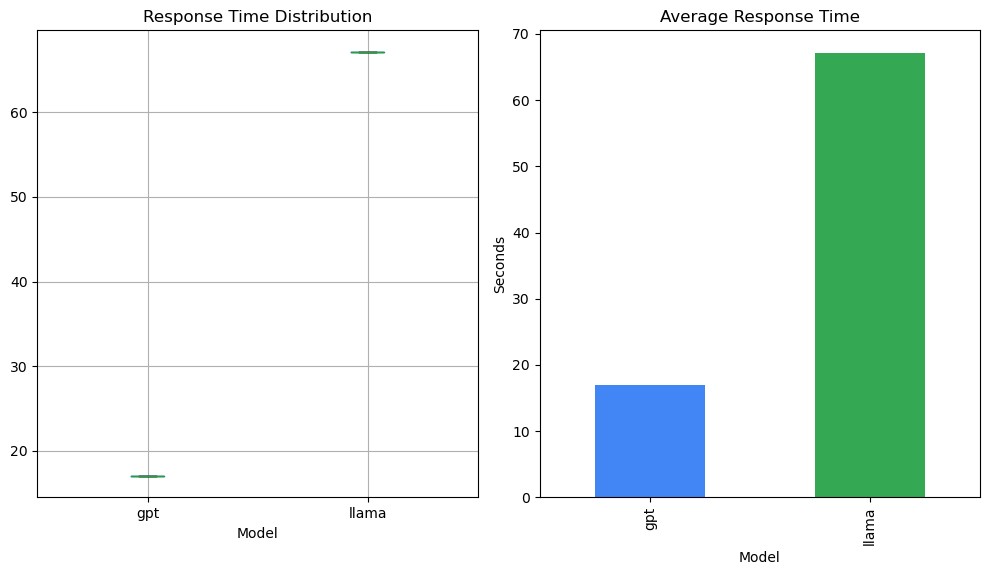

In [12]:

# Show performance metrics
tutor.show_performance_metrics()


In [13]:

# Save history to a file
tutor.save_history("my_tutor_session.json")


History saved to my_tutor_session.json

In [14]:
# Define a new question
new_question = "Explain how to implement a binary search algorithm in Python."

console.print(Panel(f"[bold]New Question:[/bold]\n{new_question}", border_style="green"))

# Get responses for the new question
new_responses = tutor.ask(new_question)

# Compare responses
tutor.compare_responses()


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ New Question:                                                                                                   │
│ Explain how to implement a binary search algorithm in Python.                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Getting response from gpt-4o-mini...                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Binary search is an efficient algorithm for finding a target value within a sorted array. It operates by repeatedly dividing the search interval in half, which makes it much faster than linear search, especially for large datasets. Here’s how to implement the binary search algorithm in Python, step by step:

### Prerequisites
- The array (or list) must be sorted in ascending order.
- You need to know the basic structure of a Python function.

### Implementation Steps

1. **Define the Function:**
   Start by defining a function that takes three parameters: the sorted array, the target value you want to find, and the indices for the starting and ending points of the search.

2. **Using a Loop or Recursion:**
   You can implement binary search using either iteration (loop) or recursion. Below, I'll cover both methods.

### Iterative Approach

Here’s a common iterative implementation of the binary search algorithm:


def binary_search_iterative(arr, target):
    left, right = 0, len(arr) - 1  # Initialize the left and right pointers

    while left <= right:  # Continue while the search space is valid
        mid = left + (right - left) // 2  # Calculate mid index to prevent overflow

        # Check if the target is at mid
        if arr[mid] == target:
            return mid  # return the index if found
        elif arr[mid] < target:
            left = mid + 1  # Target is in the right half, move left pointer
        else:
            right = mid - 1  # Target is in the left half, move right pointer

    return -1  # Target not found


### Explanation of the Iterative Version:

- **Initialization:** `left` is initialized to the first index (0) and `right` to the last index (length of the array - 1).
- **While Loop:** The loop continues as long as `left` is less than or equal to `right`.
- **Mid Calculation:** `mid` is calculated to find the middle index (this cleverly avoids overflow).
- **Comparison:** 
  - If the element at `mid` is equal to the `target`, the function returns `mid`.
  - If the element at `mid` is less than the `target`, it means the target can only be in the right half of the array, so `left` is updated to `mid + 1`.
  - If the element at `mid` is greater than the `target`, it means the target can only be in the left half, so `right` is updated to `mid - 1`.
- **Return Value:** If the loop ends without finding the target, the function returns -1.

### Recursive Approach

Here’s how to implement the binary search algorithm using recursion:


def binary_search_recursive(arr, target, left, right):
    if left > right:  # Base condition
        return -1  # Target not found

    mid = left + (right - left) // 2  # Calculate mid index

    if arr[mid] == target:
        return mid  # Return the index if found
    elif arr[mid] < target:
        return binary_search_recursive(arr, target, mid + 1, right)  # Search the right half
    else:
        return binary_search_recursive(arr, target, left, mid - 1)  # Search the left half


### Explanation of the Recursive Version:

- **Base Condition:** It first checks if the search space is valid. If `left` is greater than `right`, it returns -1 (target not found).
- **Mid Calculation:** Similar to the iterative method, it calculates the mid index.
- **Comparison:**
  - If the element at `mid` is equal to `target`, it returns `mid`.
  - If the element at `mid` is less than the `target`, it makes a recursive call to search the right half.
  - If the element at `mid` is greater than the `target`, it makes a recursive call to search the left half.
  
- Each recursive call reduces the search space by half, ensuring the algorithm remains efficient.

### Example Usage

You can test the functions using a sorted list and a target value:


sorted_list = [1, 3, 5, 7, 9, 11, 13, 15, 17]
target_value = 7

# Using iterative approach
result_iterative = binary_search_iterative(sorted_list, target_value)
print(f"Iterative: Element {target_value} found at index: {result_iterative}")

# Using recursive approach
result_recursive = binary_search_recursive(sorted_list, target_value, 0, len(sorted_list) - 1)
print(f"Recursive: Element {target_value} found at index: {result_recursive}")


### Complexity Analysis

- **Time Complexity:** O(log n) because the search space is halved with each step.
- **Space Complexity:**
  - Iterative: O(1) since it uses constant space.
  - Recursive: O(log n) due to the call stack depth for recursive calls.

### Conclusion

In summary, binary search is a powerful algorithm for searching in sorted arrays, and its implementation can be done easily in Python using both iterative and recursive methods. Understanding both approaches can reinforce your grasp of algorithm design.

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Getting response from llama3.2...                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## llama3.2 Response
**Implementing Binary Search Algorithm in Python**
=====================================================

Binary search is an efficient algorithm for finding an item from a sorted list of items. It works by repeatedly dividing in half the portion of the list that could contain the item, until you've narrowed down the possible locations to just one.

### Why Binary Search?

Binary search has a time complexity of O(log n), making it much faster than linear search (O(n)) for large datasets. This is because binary search reduces the number of elements to search by half with each iteration.

### Implementation

Here's a step-by-step implementation of the binary search algorithm in Python:

```python
def binary_search(arr, target):
    """
    Searches for an element in a sorted array using binary search.

    Args:
        arr (list): The sorted list to search.
        target: The value to search for.

    Returns:
        int: The index of the target if found, -1 otherwise.
    """

    # Initialize the low and high pointers
    low = 0
    high = len(arr) - 1

    while low <= high:
        # Calculate the mid index
        mid = (low + high) // 2

        # Compare the middle element to the target
        if arr[mid] == target:
            return mid  # Return the index of the target
        elif arr[mid] < target:
            low = mid + 1  # Move the low pointer to the right half
        else:
            high = mid - 1  # Move the high pointer to the left half

    # If we've reached this point, the target was not found
    return -1


# Example usage:

arr = [2, 5, 8, 12, 16, 23, 38, 56, 72, 91]
target = 23

result = binary_search(arr, target)

if result != -1:
    print(f"Target found at index {result}")
else:
    print("Target not found in the array")
```

### Explanation

Here's a breakdown of how the algorithm works:

1. Initialize two pointers, `low` and `high`, to represent the range of indices we need to search.
2. Calculate the middle index `mid = (low + high) // 2`.
3. Compare the element at `arr[mid]` to the target value:
	* If they match, return the `mid` index as the result.
	* If `arr[mid]` is less than the target, move the `low` pointer to `mid + 1`, narrowing down the search range to the right half.
	* If `arr[mid]` is greater than the target, move the `high` pointer to `mid - 1`, narrowing down the search range to the left half.
4. Repeat steps 2-3 until we find the target or the search range is empty (i.e., `low > high`).
5. If we reach this point, return -1 to indicate that the target was not found in the array.

### Time and Space Complexity

The binary search algorithm has a time complexity of O(log n), making it much faster than linear search for large datasets. The space complexity is O(1) since we only use a constant amount of extra memory to store the pointers.